In [4]:
# Step 1: Import Necessary Libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
import warnings
warnings.filterwarnings('ignore')

# Step 2: Load the Resampled Dataset
current_dir = os.getcwd()
resampled_dataset_path = os.path.join(current_dir, '..', 'results', 'fair_smote_adult.csv')
df = pd.read_csv(resampled_dataset_path)
print(f"Dataset loaded. Shape: {df.shape}")

# Step 3: Prepare the Data for Modeling
label_column = 'income'
protected_attributes = ['sex', 'race']
X = df.drop(columns=[label_column])
y = df[label_column]

# Check for missing values
if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    print("Data contains missing values.")
else:
    print("No missing values found.")

# Ensure all features are numeric
non_numeric_cols = X.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f"Non-numeric columns found: {non_numeric_cols}")
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for col in non_numeric_cols:
        X[col] = le.fit_transform(X[col])
else:
    print("All features are numeric.")

# Step 4: Split the Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 5: Train a Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
train_accuracy_rf = rf_model.score(X_train, y_train)
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
test_roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print(f"Random Forest Training Accuracy: {train_accuracy_rf:.4f}")
print(f"Random Forest Test Accuracy: {test_accuracy_rf:.4f}")
print(f"Random Forest Test ROC AUC: {test_roc_auc_rf:.4f}")

# Step 6: Train a Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
train_accuracy_dt = dt_model.score(X_train, y_train)
test_accuracy_dt = accuracy_score(y_test, y_pred_dt)
test_roc_auc_dt = roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1])
print(f"Decision Tree Training Accuracy: {train_accuracy_dt:.4f}")
print(f"Decision Tree Test Accuracy: {test_accuracy_dt:.4f}")
print(f"Decision Tree Test ROC AUC: {test_roc_auc_dt:.4f}")

# Step 7: Define Functions for Intersectional Fairness Metrics
def calculate_wc_spd(df, label_column, protected_attributes):
    group_stats = []
    total_instances = len(df)
    for combination in df.groupby(protected_attributes):
        _, subset = combination
        favorable_prob = subset[label_column].mean()
        weight = len(subset) / total_instances
        group_stats.append((favorable_prob, weight))
    wc_spd = sum(weight * prob for prob, weight in group_stats)
    return wc_spd

def calculate_wc_aod(df, label_column, protected_attributes, y_pred_col):
    group_stats = []
    total_instances = len(df)
    for combination in df.groupby(protected_attributes):
        _, subset = combination
        tpr = sum((subset[label_column] == 1) & (subset[y_pred_col] == 1)) / sum(subset[label_column] == 1)
        fpr = sum((subset[label_column] == 0) & (subset[y_pred_col] == 1)) / sum(subset[label_column] == 0)
        weight = len(subset) / total_instances
        group_stats.append((tpr, fpr, weight))
    wc_aod = sum(weight * (tpr - fpr) for tpr, fpr, weight in group_stats)
    return wc_aod

def calculate_ac_spd(df, label_column, protected_attributes):
    group_stats = []
    for combination in df.groupby(protected_attributes):
        _, subset = combination
        favorable_prob = subset[label_column].mean()
        group_stats.append(favorable_prob)
    spd_values = [abs(prob1 - prob2) for i, prob1 in enumerate(group_stats) 
                  for j, prob2 in enumerate(group_stats) if i < j]
    ac_spd = sum(spd_values) / len(spd_values) if spd_values else 0
    return ac_spd


Dataset loaded. Shape: (74310, 98)
No missing values found.
All features are numeric.
Random Forest Training Accuracy: 0.9999
Random Forest Test Accuracy: 0.9043
Random Forest Test ROC AUC: 0.9683
Decision Tree Training Accuracy: 1.0000
Decision Tree Test Accuracy: 0.8765
Decision Tree Test ROC AUC: 0.8765
Random Forest WC-SPD: 0.5000
Random Forest WC-AOD: 0.8085
Random Forest AC-SPD: 0.0000
Decision Tree WC-SPD: 0.5000
Decision Tree WC-AOD: 0.7529
Decision Tree AC-SPD: 0.0000


In [6]:
# Step 8: Calculate Fairness Metrics for Random Forest
df_test_rf = X_test.copy()
df_test_rf[label_column] = y_test.values
df_test_rf['y_pred'] = y_pred_rf
wc_spd_rf = calculate_wc_spd(df_test_rf, label_column, protected_attributes)
wc_aod_rf = calculate_wc_aod(df_test_rf, label_column, protected_attributes, 'y_pred')
ac_spd_rf = calculate_ac_spd(df_test_rf, label_column, protected_attributes)
print(f"Random Forest WC-SPD: {wc_spd_rf:.4f}")
print(f"Random Forest WC-AOD: {wc_aod_rf:.4f}")
print(f"Random Forest AC-SPD: {ac_spd_rf:.4f}")


Random Forest WC-SPD: 0.5000
Random Forest WC-AOD: 0.8085
Random Forest AC-SPD: 0.0000


In [7]:
# Step 9: Calculate Fairness Metrics for Decision Tree
df_test_dt = X_test.copy()
df_test_dt[label_column] = y_test.values
df_test_dt['y_pred'] = y_pred_dt
wc_spd_dt = calculate_wc_spd(df_test_dt, label_column, protected_attributes)
wc_aod_dt = calculate_wc_aod(df_test_dt, label_column, protected_attributes, 'y_pred')
ac_spd_dt = calculate_ac_spd(df_test_dt, label_column, protected_attributes)
print(f"Decision Tree WC-SPD: {wc_spd_dt:.4f}")
print(f"Decision Tree WC-AOD: {wc_aod_dt:.4f}")
print(f"Decision Tree AC-SPD: {ac_spd_dt:.4f}")


Decision Tree WC-SPD: 0.5000
Decision Tree WC-AOD: 0.7529
Decision Tree AC-SPD: 0.0000


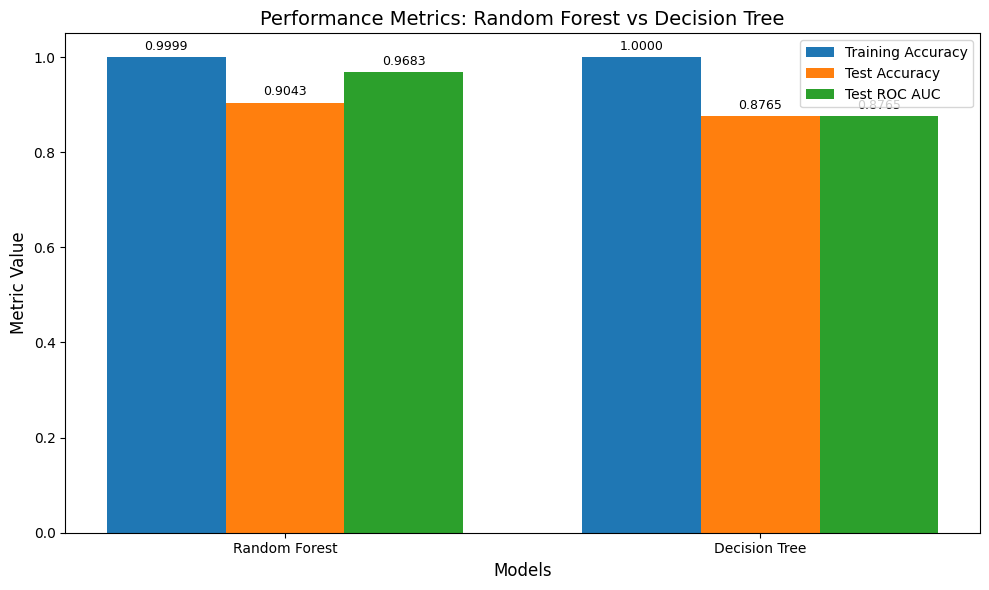

In [5]:
# Plotting performance metrics manually
import matplotlib.pyplot as plt
import numpy as np

# Define performance metrics
models = ['Random Forest', 'Decision Tree']
training_accuracy = [0.9999, 1.0000]
test_accuracy = [0.9043, 0.8765]
test_roc_auc = [0.9683, 0.8765]

# Plotting
x = np.arange(len(models))  # label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, training_accuracy, width, label='Training Accuracy')
bar2 = ax.bar(x, test_accuracy, width, label='Test Accuracy')
bar3 = ax.bar(x + width, test_roc_auc, width, label='Test ROC AUC')

# Add labels, title, and legend
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Metric Value', fontsize=12)
ax.set_title('Performance Metrics: Random Forest vs Decision Tree', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=10)
ax.legend()

# Adding value annotations
for bar_group in [bar1, bar2, bar3]:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
